We start by adding the necessary folders to the current working path.

In [1]:
# import sys/os
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add HyperbolicsLCS folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/HyperbolicLCS")

# Overview

In the following notebook we extract hyperbolic LCS from tensorlines of the eigenvector field associated to the minimum/maximum eigenvalue of the Cauchy Green strain tensor a two-dimensional, satellite-altimetry-derived ocean-surface current product (AVISO). The notebook is structured as follows:

1. Import data from the file 'AVISO.mat' stored in the folder 'data/AVISO'.
<br />
2. Define computational parameters and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from (discrete) gridded data.
 <br />
5. Hyperbolic LCS from forward computation:

    * Compute gradient of flow map $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $ over meshgrid using an auxiliary grid. 
    <br />
    
    * Compute Cauchy Green (CG) strain tensor as: 
    <br />
    
    \begin{equation} \mathbf{C}_{t_0}^{t_N}(\mathbf{x}_0) = \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0)^T\mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0). \end{equation}
   <br />
   
    * Compute maximum eigenvalues $ \lambda_2(\mathbf{x}_0) $ of $ \mathbf{C}_{t_0}^{t_N}(\mathbf{x}_0) $.
    <br />
    
    * Compute repelling LCS (extracted over the time-interval $ [t_0, t_N] $) at time $ t_0 $ as tensorlines tangent to the eigenvector field $ \mathbf{\xi_1(\mathbf{x})} $ associated to the minimum eigenvalue $ \lambda_1(\mathbf{x}) $ of $ \mathbf{C}_{t_0}^{t_N}(\mathbf{x}_0) $:
    <br />
    
    \begin{equation}
    \dfrac{d}{ds} \mathbf{x}(s) =  \mathbf{\xi_1(\mathbf{x})}
    \end{equation}
    <br />
    
    For repelling LCS, the tensorlines are launched from local maxima of the $ \lambda_2(\mathbf{x}) $-field.
    <br />
    
    * Compute attracting LCS (extracted over the time-interval $ [t_0, t_N] $) at time $ t_0 $ as tensorlines tangent to the eigenvector field $ \mathbf{\xi_2(\mathbf{x})} $ associated to the maximum eigenvalue $ \lambda_2(\mathbf{x}) $ of $ \mathbf{C}_{t_0}^{t_N}(\mathbf{x}_0) $:
    <br />
    
    \begin{equation}
    \dfrac{d}{ds} \mathbf{x}(s) =  \mathbf{\xi_2(\mathbf{x})}
    \end{equation}
    <br />
    
    For attracting LCS, the tensorlines are launched from local minima of the $ \lambda_1(\mathbf{x}) $-field.
    <br />
    
    In case of an incompressible flow (as here) local maxima of the $ \lambda_2(\mathbf{x}) $-field coincide with local minima of the $ \lambda_1({\mathbf{x}}) $-field as $ \lambda_2(\mathbf{x}) = \dfrac{1}{\lambda_1(\mathbf{x})} $. 
    <br />
    
    Note that we compute repelling and attracting LCS from a single forward computation. Similarly repelling and attracting LCS can be computed from a single backward computation. Due to the unavoidable orientational discontinuities of the eigenvector-field, the integration has to be performed manually by checking the orientation of the eigenvector at every integration-step. If the orientation is not equivalent to the orientation of the eigenvector at the previous integration step, then the eigenvector has to be flipped before integrating.
 <br />
7. References

# Import data

In [2]:
# import scipy
import scipy.io as sio

# Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/Aviso/AVISO.mat')

U = mat_file['u'] # array (NY, NX, NT)
V = mat_file['v'] # array (NY, NX, NT)
x = mat_file['x'] # array (NY, NX)
y = mat_file['y'] # array (NY, NX)
time_data = mat_file['t'] # array (1, NT)

# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
# import numpy
import numpy as np

# Number of cores for parallel computing
Ncores = 5 # int

# Time resolution of data
dt_data = time_data[0, 1]-time_data[0,0] # float

# Periodic boundary conditions
periodic_x = False # bool
periodic_y = False # bool
periodic_t = False # bool
periodic = [periodic_x, periodic_y, periodic_t]

# Unsteady velocity field
bool_unsteady = True # bool

# Defined domain
defined_domain = np.isfinite(U[:,:,0]).astype(int) # array (NY, NX)

## Compute meshgrid of dataset
X, Y = np.meshgrid(x, y) # array (NY, NX), array (NY, NX)

## Resolution of meshgrid
dx_data = X[0,1]-X[0,0] # float
dy_data = Y[1,0]-Y[0,0] # float

delta = [dx_data, dy_data] # list (2, )

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
# Initial time (in days)
t0 = 0 # float

# Final time (in days)
tN = 25 # float

# Time step-size (in days)
dt = .1 # float

# NOTE: For computing the backward trajectories set: tN < t0 and dt < 0.

time = np.arange(t0, tN+dt, dt) # shape (Nt,)

# Length of time interval (in days)
lenT = abs(tN-t0) # float

# Longitudinal and latitudinal boundaries (in degrees)
xmin = -3.5 # float
xmax = 1 # float
ymin = -32 # float
ymax = -24 # float

# Make sure that the chosen domain is part of the data domain
assert np.min(X) <= xmin <= np.max(X), " xmin must be between "+f'{np.min(X)} and {np.max(X)}'
assert np.min(X) <= xmax <= np.max(X), " xmax must be between "+f'{np.min(X)} and {np.max(X)}'
assert np.min(Y) <= ymin <= np.max(Y), " ymin must be between "+f'{np.min(Y)} and {np.max(Y)}'
assert np.min(Y) <= ymax <= np.max(Y), " ymax must be between "+f'{np.min(Y)} and {np.max(Y)}'
assert np.min(time_data) <= t0 <= np.max(time_data), " t0 must be between "+f'{np.min(time_data)} and {np.max(time_data)}'
assert np.min(time_data) <= tN <= np.max(time_data), " tN must be between "+f'{np.min(time_data)} and {np.max(time_data)}'

# Spacing of meshgrid (in degrees)
dx = 0.02 # float
dy = 0.02 # float

x_domain = np.arange(xmin, xmax + dx, dx) # array (Nx, )
y_domain = np.arange(ymin, ymax + dy, dy) # array (Ny, )

X_domain, Y_domain = np.meshgrid(x_domain, y_domain) # array (Ny, Nx)

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .2 # float between [1/100, 1/5]
aux_grid = [aux_grid_ratio*(X_domain[0, 1]-X_domain[0, 0]), aux_grid_ratio*(Y_domain[1, 0]-Y_domain[0, 0])] # list (2, )

# Interpolate velocity

In order to evaluate the velocity field at arbitrary locations and times, we interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". Defulat value is "cubic".

In [5]:
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Set nan values to zero (in case there are any) so that we can apply interpolant. 
# Interpolant does not work if the array contains nan values. 
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, method = "cubic")

Interpolant_u = Interpolant[0] # RectangularBivariateSpline-object
Interpolant_v = Interpolant[1] # RectangularBivariateSpline-object

# Hyperbolic LCS from forward computation

## Cauchy Green (CG) strain tensor

The Cauchy Green strain tensor $ C_{t_0}^t(\mathbf{x}) $ is computed by using an auxiliary meshgrid.

In [6]:
# Import function to compute gradient of flow map
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# Import function to compute Cauchy-Green strain tensor
from ipynb.fs.defs.CauchyGreen import CauchyGreen

# Import package for parallel computing
from joblib import Parallel, delayed

# Split x0, y0 into 'Ncores' equal batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

def parallel_C(x0_batch, y0_batch):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch]) # array (2, Nx*Ny)

    # Compute gradient of flow map
    gradFmap = gradient_flowmap(time, X0, X, Y, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, aux_grid) # shape (N, Nx*Ny, 2, 2)

    # extract gradient from t0 to tN
    gradFmap_t0_tN = gradFmap[-1,:, :, :] # array (N, 2, 2, Nx*Ny)

    # compute CG
    C = gradFmap_t0_tN.copy()*np.nan
    for i in range(gradFmap_t0_tN.shape[2]):
        C[:,:,i] = CauchyGreen(gradFmap_t0_tN[:,:,i]) # array (2, 2, Nx*Ny)
    
    return C

In [7]:
# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny, )
x0 = X_domain.ravel() # array (Nx*Ny,)
y0 = Y_domain.ravel() # array (Nx*Ny,)

x0_batch = list(split(x0, Ncores)) # list (Nx*Ny,)
y0_batch = list(split(y0, Ncores)) # list (Nx*Ny,)

results = Parallel(n_jobs=Ncores, verbose = 50)(delayed(parallel_C)(x0_batch[i], y0_batch[i]) for i in range(len(x0_batch)))

# extract CG tensorfield from results of parallel computing
C = results[0]

for res in results[1:]:
    C = np.append(C, res, axis = 2)
    
# reshape array from vectorized form to structured meshgrid
C = C.reshape((2, 2, X_domain.shape[0], X_domain.shape[1])) # array (2, 2, Ny, Nx)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:   58.0s
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   59.3s remaining:  1.5min
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:  1.0min remaining:   40.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.0min finished


## Eigenvalues/Eigenvectors of Cauchy Green strain tensor

We now compute the eigenvalues and eigenvectors of Cauchy Green strain tensor. We additionally also compute the $ \mathrm{FTLE}_{t_0}^{t_N} $ as we seek to later compare the repelling LCS with features of the FTLE-field.

In [8]:
# Import function to compute eigenvalues/eigenvectors
from ipynb.fs.defs.eigen import eigen

# Import function to check location of particle
from ipynb.fs.defs.check_location import check_location

# add FTLE folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/FTLE2D")

# Import function to calculate FTLE from Cauchy-Green strain tensor
from ipynb.fs.defs.FTLE import _FTLE_C

# maximum eigenvalues of CG-tensor
eig1 = C[0,0,:,:].copy()*np.nan # array (Ny, Nx)
# minimum eigenvalues of CG-tensor
eig2 = C[0,0,:,:].copy()*np.nan # array (Ny, Nx)
# eigenvectors associated to maximum eigenvalues of CG-tensor
e1 = np.zeros((eig1.shape[0], eig1.shape[1], 2))*np.nan # array (Ny, Nx, 2)
# eigenvectors associated to minimum eigenvalues of CG-tensor
e2 = np.zeros((eig2.shape[0], eig2.shape[1], 2))*np.nan # array (Ny, Nx, 2)
# FTLE-field
FTLE = C[0,0,:,:].copy()*np.nan # array (Ny, Nx)

#iterate over meshgrid
for i in range(X_domain.shape[0]):
    
    for j in range(Y_domain.shape[1]):
            
        x = [X_domain[i,j], Y_domain[i, j]]
        
        # only compute CG tensor for trajectories starting region where velocity field is defined
        if check_location(X, Y, defined_domain, np.array(x))[0] == "IN":
        
            # compute eigenvalues of CG tensor
            eig1[i,j], eig2[i,j], e1[i,j,:], e2[i,j,:] = eigen(C[:,:,i,j])
            
            # compute FTLE-field from CG tensor
            FTLE[i, j] = _FTLE_C(C[:,:,i,j], lenT)

## Shrinklines (Repelling LCS)

Repelling LCS can be sought among trajectories of the differential equation:

\begin{equation}
\mathbf{x}'_0(s) = \xi_1(\mathbf{x}_0;t_0, t_N),
\label{eq: shrinklines}
\end{equation}

with $ \xi_1 $ denoting the eigenvector associated to the weakest eigenvalue $ \lambda_1 $ of $ C_{t_0}^{t_N}(\mathbf{x}_0) $. The non-orientable vector field is well defiend away from tensorline singularites (points where $ \lambda_1 = \lambda_2 $).
The most repelling shrinklines mark initial positions of repelling LCSs. Repelling LCSs can therefore be located as trajectories of eq. \ref{eq: shrinklines} that have locally the largest averaged $ \lambda_2(\mathbf{x}_0;t_0, t_N) $ among all neighbouring shrinklines.

In [9]:
# import function to compute tensorlines
from ipynb.fs.defs.tensorlines import _tensorlines

# Step-size used for integration
step_size = 0.05 # float

# Threshold distance to locate local maxima in the 'eig2'
max_distance = 0.1 # float

# Maximum length of shrinkline
max_length = 5 # float

# Compute shrinklines 
shrinklines = _tensorlines(X_domain, Y_domain, eig2, e1, max_distance, max_length, step_size) # list containing shrinklines

## Stretchlines (Attracting LCS)

Attracting LCS can be sought among trajectories of the differential equation:

\begin{equation}
\mathbf{x}'_0 = \xi_2(\mathbf{x}_0;t_0, t_N),
\label{eq: stretchlines}
\end{equation}

with $ \xi_2 $ denoting the eigenvector associated to the strongest eigenvalue $ \lambda_2 $ of $ C_{t_0}^{t_N}(\mathbf{x}_0) $. The non-orientable vector field is well defiend away from tensorline singularites (points where $ \lambda_1 = \lambda_2 $).
The most attracting stretchlines mark initial positions of attracting LCSs. Attracting LCSs can therefore be located as trajectories of eq. \ref{eq: stretchlines} that have locally the smallest averaged $ \lambda_1(\mathbf{x}_0;t_0, t_N) $ among all neighbouring stretchlines.

In [10]:
# Step-size used for integration
step_size = 0.05 # float

# threshold distance to locate local maxima in the 'eig2'
max_distance = 0.1 # float

# Maximum length of stretchline
max_length = 5 # float

# Compute stretchlines
stretchlines = _tensorlines(X_domain, Y_domain, eig2, e2, max_distance, max_length, step_size) # list containing stretchlines

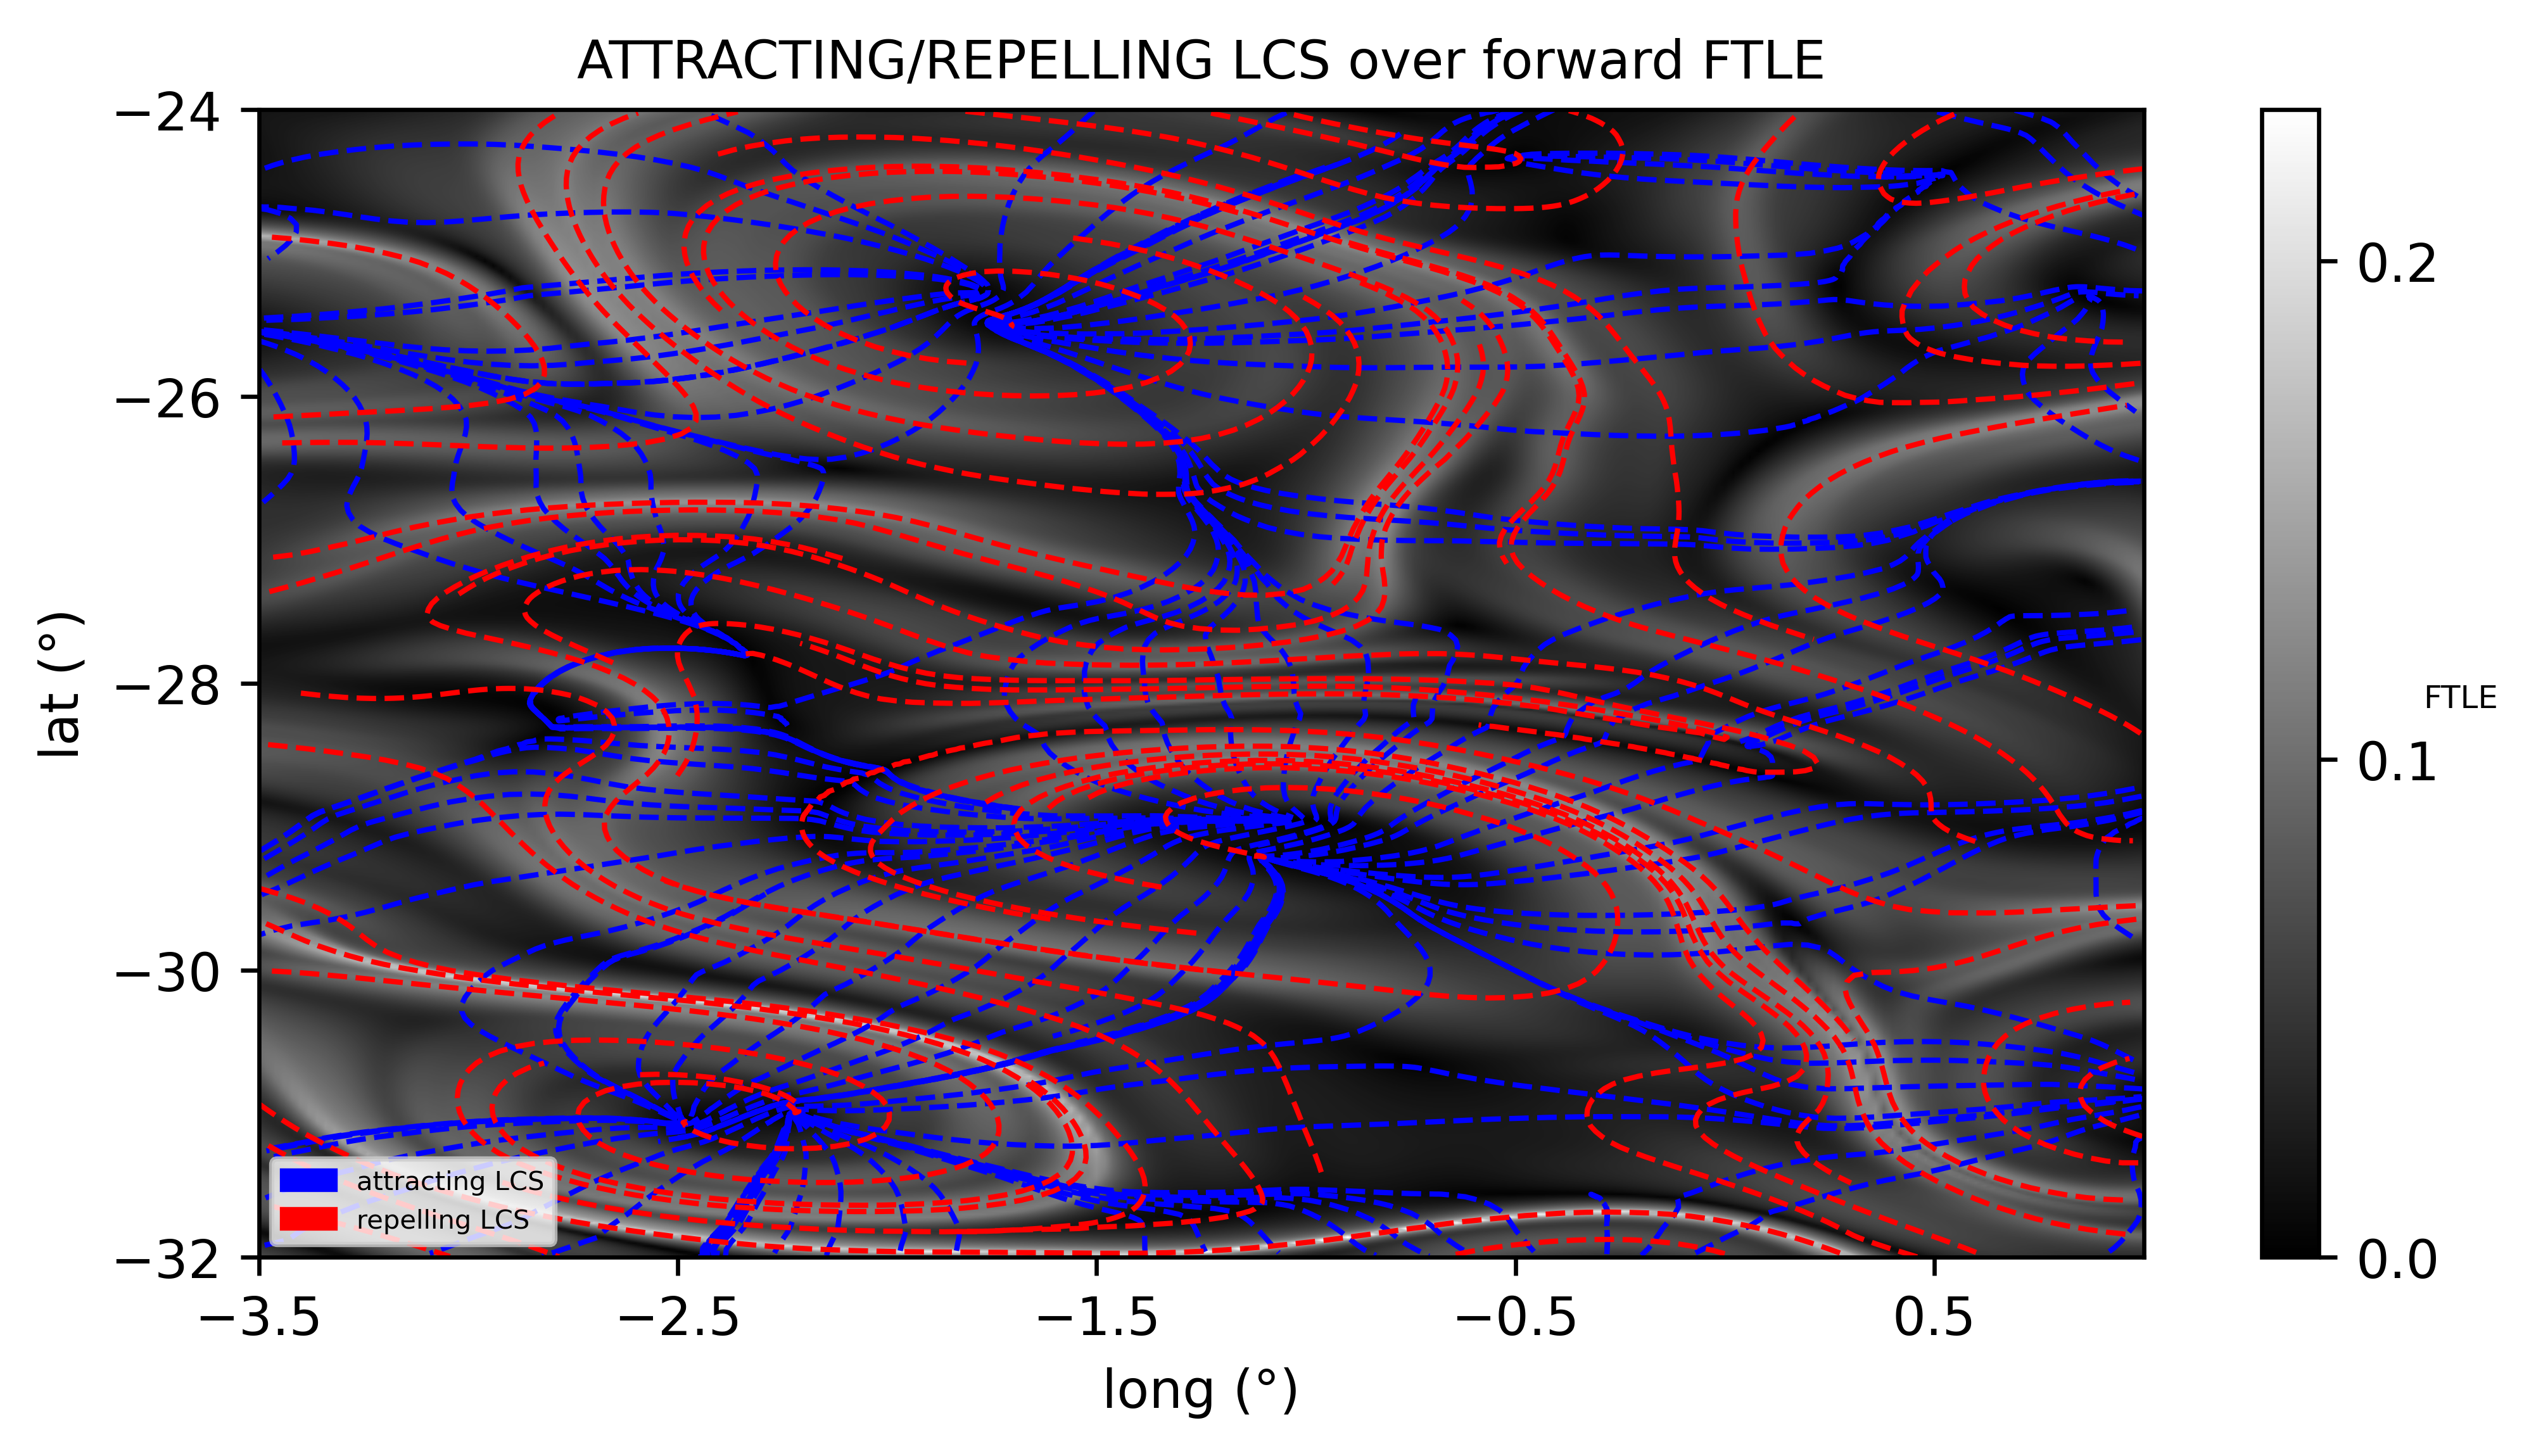

In [11]:
############################################ PLOT RESULTS ############################################
import matplotlib.pyplot as plt

# Define figure/axes
fig = plt.figure(figsize = (8, 4), dpi = 600)
ax = plt.axes()

for i in range(len(stretchlines[0])):
    ax.plot(stretchlines[0][i], stretchlines[1][i], c = 'b', linewidth = 1, linestyle = "dashed")
    
for i in range(len(shrinklines[0])):
    ax.plot(shrinklines[0][i], shrinklines[1][i], c = 'r', linewidth = 1, linestyle = "dashed")
    
# add FTLE field to plot
cax = ax.contourf(X_domain, Y_domain, np.ma.masked_invalid(FTLE), levels = 400, cmap = "gist_gray")    

# Set axis limits
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

# Set axis ticks
ax.set_xticks(np.arange(xmin, xmax+0.1, 1))
ax.set_yticks(np.arange(ymin, ymax+0.1, 2))

# Set axis labels
ax.set_xlabel("long (°)", fontsize = 10)
ax.set_ylabel("lat (°)", fontsize = 10)

# Colorbar
cbar = fig.colorbar(cax, ticks = np.arange(0, 1, 0.1))
cbar.ax.set_ylabel(r'FTLE', rotation = 0, fontsize = 6)

# Plot legend
import matplotlib.patches as mpatches
attracting = mpatches.Patch(color='b', label='attracting LCS')
repelling = mpatches.Patch(color='r', label='repelling LCS')
plt.legend(handles=[attracting, repelling], fontsize = 5,  loc = "lower left")

# Title
ax.set_title("ATTRACTING/REPELLING LCS over forward FTLE", fontsize = 10)
plt.show();

Similarly, we can obtain both repelling and attracting LCS at time $ t_N $ from a single backward computation of the backward flow map $ \mathbf{F}_{t_N}^{t_0}(\mathbf{x}_0) $. Obtaining positions of repelling LCSs at time $ t \in [t_0, t_N] $ from the forward forward computation remains problematic as it requires the forward advection of a discrete approximation of the repelling LCSs under the flow map $ \mathbf{F}_{t_0}^{t}(\mathbf{x}_0) $, generating exponentially growing errors. An analogous statement holds for attracting LCSs at time $ t_N $ by using backward advection under the backward flow map $ \mathbf{F}_{t_N}^{t}(\mathbf{x}_0) $.

Compared to the $ \mathrm{FTLE} $ field, which is only a diagnostic quantity used for visualizing possible hyperbolic LCSs, the repelling/attracting LCSs derived from the tensorline computation are precise indicators of hyperbolic LCSs. As expected repelling LCS (red solid lines) match well with ridges of the $ \mathrm{FTLE} $ field. Furthermore, due to the orthogonality of the two eigenvector fields $ \mathbf{\xi}_1 $ and $ \mathbf{\xi}_2 $, repelling LCS need always be orthogonal to attracting LCS. Intersections of repelling and attracting LCSs are referred to as generalized finite-time saddles[1, 2, 3].

# References

[1] Farazmand, M., & Haller, G. (2012). Computing Lagrangian coherent structures from their variational theory. Chaos: An Interdisciplinary Journal of Nonlinear Science, 22(1), 013128.

[2] Farazmand, M., & Haller, G. (2013). Attracting and repelling Lagrangian coherent structures from a single computation. Chaos: An Interdisciplinary Journal of Nonlinear Science, 23(2), 023101.

[3] Onu, K., Huhn, F., & Haller, G. (2015). LCS Tool: A computational platform for Lagrangian coherent structures. Journal of Computational Science, 7, 26-36.

[4] Notebook 5.3.2 in "Transport Barriers and Coherent Structures in Flow Data" by Prof. George Haller.